# -  Imports

In [1]:
import tensorflow as tf
import torchaudio
import sys,os
import pandas as pd
import numpy as np
from numpy.random import randint
import matplotlib.pyplot as plt
import librosa
import librosa.display
import re

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# models
from sklearn import linear_model, naive_bayes, neighbors
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from scipy import stats

# Libraries for the Accuracy Evaluation
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
%matplotlib inline

# -  Data Loading & Feature Extraction

In [2]:
sample_rate = 16000
def extract_features(audio):
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    return mfccs

*Extract Audio Files from Tar*

In [3]:
!tar -xvf  'dev-clean.tar'

LibriSpeech/LICENSE.TXT
LibriSpeech/README.TXT
LibriSpeech/CHAPTERS.TXT
LibriSpeech/SPEAKERS.TXT
LibriSpeech/BOOKS.TXT
LibriSpeech/dev-clean/
LibriSpeech/dev-clean/2277/
LibriSpeech/dev-clean/2277/149896/
LibriSpeech/dev-clean/2277/149896/2277-149896-0026.flac
LibriSpeech/dev-clean/2277/149896/2277-149896-0005.flac
LibriSpeech/dev-clean/2277/149896/2277-149896-0033.flac
LibriSpeech/dev-clean/2277/149896/2277-149896-0006.flac
LibriSpeech/dev-clean/2277/149896/2277-149896-0018.flac
LibriSpeech/dev-clean/2277/149896/2277-149896-0034.flac
LibriSpeech/dev-clean/2277/149896/2277-149896-0021.flac
LibriSpeech/dev-clean/2277/149896/2277-149896-0015.flac
LibriSpeech/dev-clean/2277/149896/2277-149896-0012.flac
LibriSpeech/dev-clean/2277/149896/2277-149896-0027.flac
LibriSpeech/dev-clean/2277/149896/2277-149896-0007.flac
LibriSpeech/dev-clean/2277/149896/2277-149896-0030.flac
LibriSpeech/dev-clean/2277/149896/2277-149896-0011.flac
LibriSpeech/dev-clean/2277/149896/2277-149896-0009.flac
LibriSpeech

In [4]:
# 2703 audio files

root = "LibriSpeech/dev-clean/"
df = pd.DataFrame(columns=['speaker_id', 'features'])              

i = 0
max_pad_len = 1021

# loading the features in the first dataframe
for path, subdirs, files in os.walk(root):
    for name in files:
        speaker_id = path.split('/')[2]
        if name.endswith(".flac"):
            sound, sample_rate = librosa.load(os.path.join(path, name), sr=16000)
            data = extract_features(sound)
            pad_width = max_pad_len - data.shape[1]
            data = np.pad(data, pad_width=((0,0), (0, pad_width)), mode='constant')
            df.loc[i] = [speaker_id] + [data]
            i += 1
            
# loading the labels in the second dataframe
root = "LibriSpeech/"
labels = pd.DataFrame(columns=['speaker_id', 'gender'])

f = open("LibriSpeech/SPEAKERS.TXT", "r", encoding="UTF8").readlines()
i = 0
for idx, line in enumerate(f):
    if idx > 11:
        parsed = re.split('\s+',line)
        if parsed[4] == 'dev-clean':
            # speaker_id and label (M/F)
            labels.loc[i] = parsed[0], parsed[2] 
            i += 1

# merging the two dataframes.
dataset = pd.merge(df, labels, on='speaker_id')

# Encoding
dataset["gender"].replace({"M": 1, "F": 0}, inplace=True)
dataset.head(5)

,speaker_id,features,gender
0,5536,"[[-526.97687, -521.2252, -519.8892, -516.05927...",1
1,5536,"[[-524.88416, -521.9767, -523.7086, -527.70465...",1
2,5536,"[[-524.24994, -517.539, -518.1789, -519.146, -...",1
3,5536,"[[-514.6987, -513.20276, -514.66034, -509.3705...",1
4,5536,"[[-524.41644, -524.86707, -528.65405, -528.164...",1


In [5]:
dataset['gender'].value_counts()

0    1374
1    1329
Name: gender, dtype: int64

In [6]:
train_test_ratio = 0.80
n_sounds = 2703

def split_train_test(train_test_ratio, n_sounds):
    
    train = pd.DataFrame(columns=['speaker_id', 'features' , 'gender'])
    test = pd.DataFrame(columns=['speaker_id', 'features', 'gender'])
    
    train_elems = int(np.floor(n_sounds*train_test_ratio))
    test_elems = n_sounds - train_elems

    male_train = int(np.floor(dataset['gender'].value_counts()[0]* train_test_ratio))
    male_test = int(np.ceil(dataset['gender'].value_counts()[0]* (1-train_test_ratio)))
    train_sizes = [male_train, train_elems]
    test_sizes = [male_test + male_train, n_sounds]
    
    for gender in range(2):  
        if gender == 0:
            # MALES
            gender_set = dataset[dataset["gender"] == gender]   
        elif gender == 1:
            # FEMALES
            gender_set = dataset[dataset["gender"] == gender]   

        ordered_gender_set = gender_set['speaker_id'].value_counts()
        i = 0
        while (train.shape[0] < train_sizes[gender]):
            train = train.append(gender_set[gender_set["speaker_id"] == ordered_gender_set.index[i]])
            i += 1
        while (test.shape[0] + train.shape[0] != test_sizes[gender]): 
            test = test.append(gender_set[gender_set["speaker_id"] == ordered_gender_set.index[i]])
            i += 1

    return train, test
   
train, test = split_train_test(train_test_ratio, n_sounds)

# ML Algorithms

In [7]:
#Features and Labels
X_train = np.mean(np.array(train.features.tolist()), axis = 2)
X_test = np.mean(np.array(test.features.tolist()), axis = 2)
y_train = np.array(train.gender.tolist())
y_test = np.array(test.gender.tolist())

le = LabelEncoder()
yy_train = to_categorical(le.fit_transform(y_train)) 
yy_test = to_categorical(le.fit_transform(y_test)) 

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2176, 40), (2176,), (527, 40), (527,))

## KNN

In [8]:
knn = neighbors.KNeighborsClassifier(19, weights='uniform')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
accuracy_knn = accuracy_score(y_test, y_pred)
print("\nAccuracy: ", accuracy_knn)
print("\nPrecision: ", precision_score(y_test, y_pred))
print("\nRecall: ", recall_score(y_test, y_pred))

Confusion Matrix:
[[185  65]
 [ 61 216]]

Accuracy:  0.7609108159392789

Precision:  0.7686832740213523

Recall:  0.779783393501805


## Naive Bayes

In [9]:
nb = naive_bayes.GaussianNB();
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
accuracy_nb = accuracy_score(y_test, y_pred)
print("\nAccuracy: ", accuracy_nb)
print("\nPrecision: ", precision_score(y_test, y_pred))
print("\nRecall: ", recall_score(y_test, y_pred))

Confusion Matrix:
[[231  19]
 [ 76 201]]

Accuracy:  0.8197343453510436

Precision:  0.9136363636363637

Recall:  0.7256317689530686


## Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
accuracy_rf = accuracy_score(y_test, y_pred)
print("\nAccuracy: ", accuracy_rf)
print("\nPrecision: ", precision_score(y_test, y_pred))
print("\nRecall: ", recall_score(y_test, y_pred))


Confusion Matrix:
[[246   4]
 [ 59 218]]

Accuracy:  0.8804554079696395

Precision:  0.9819819819819819

Recall:  0.7870036101083032


## Support Vector Machine

In [11]:
from sklearn import svm
svc = svm.SVC(kernel='poly', gamma='auto')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
accuracy_svm = accuracy_score(y_test, y_pred)
print("\nAccuracy: ", accuracy_svm)
print("\nPrecision: ", precision_score(y_test, y_pred))
print("\nRecall: ", recall_score(y_test, y_pred))

Confusion Matrix:
[[213  37]
 [ 52 225]]

Accuracy:  0.8311195445920304

Precision:  0.8587786259541985

Recall:  0.8122743682310469


## Logistic Regression

In [12]:
log = linear_model.LogisticRegression(C=1e5, solver='saga', max_iter=100, verbose=0)
log.fit(X_train, y_train)
y_pred = log.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
accuracy_log = accuracy_score(y_test, y_pred)
print("\nAccuracy: ", accuracy_log)
print("\nPrecision: ", precision_score(y_test, y_pred))
print("\nRecall: ", recall_score(y_test, y_pred))

Confusion Matrix:
[[197  53]
 [ 30 247]]

Accuracy:  0.8425047438330171

Precision:  0.8233333333333334

Recall:  0.8916967509025271


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


## Neural Network

In [13]:
mlp = MLPClassifier(random_state=42, max_iter=300)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
accuracy_mlp = accuracy_score(y_test, y_pred)
print("\nAccuracy: ", accuracy_mlp)
print("\nPrecision: ", precision_score(y_test, y_pred))
print("\nRecall: ", recall_score(y_test, y_pred))

Confusion Matrix:
[[230  20]
 [ 57 220]]

Accuracy:  0.8538899430740038

Precision:  0.9166666666666666

Recall:  0.7942238267148014


## Convolutional Neural Network

In [14]:
X_train = np.array(train.features.tolist())
X_test = np.array(test.features.tolist())
y_train = np.array(train.gender.tolist())
y_test = np.array(test.gender.tolist())

le = LabelEncoder()
yy_train = to_categorical(le.fit_transform(y_train)) 
yy_test = to_categorical(le.fit_transform(y_test))

In [16]:
X_train = X_train.reshape(X_train.shape[0], 40, 1021, 1)
X_test = X_test.reshape(X_test.shape[0], 40, 1021, 1)

print(X_train.shape, X_test.shape)

num_labels = yy_train.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=3, input_shape=(40, 1021, 1), activation='relu'))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 1)))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 26)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(Dense(num_labels, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

(2176, 40, 1021, 1) (527, 40, 1021, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 1019, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 1017, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 18, 1017, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 1015, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 1013, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 506, 128)      0         
 2D)           

In [17]:
num_epochs = 20
num_batch_size = 100

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

history = model.fit(X_train, yy_train, epochs=num_epochs, batch_size=num_batch_size, validation_data=(X_test, yy_test), callbacks=[es])

Epoch 1/20
22/22 [==============================] - 42s 1s/step - loss: 0.7523 - accuracy: 0.6016 - val_loss: 0.2710 - val_accuracy: 0.8918
Epoch 2/20
22/22 [==============================] - 19s 869ms/step - loss: 0.3330 - accuracy: 0.8892 - val_loss: 0.2847 - val_accuracy: 0.9108
Epoch 3/20
22/22 [==============================] - 19s 876ms/step - loss: 0.2850 - accuracy: 0.9164 - val_loss: 0.2890 - val_accuracy: 0.8653
Epoch 4/20
22/22 [==============================] - 19s 883ms/step - loss: 0.2412 - accuracy: 0.9251 - val_loss: 0.2204 - val_accuracy: 0.8937
Epoch 5/20
22/22 [==============================] - 19s 887ms/step - loss: 0.1800 - accuracy: 0.9403 - val_loss: 0.2003 - val_accuracy: 0.9241
Epoch 6/20
22/22 [==============================] - 19s 887ms/step - loss: 0.1135 - accuracy: 0.9568 - val_loss: 0.2052 - val_accuracy: 0.9165
Epoch 7/20
22/22 [==============================] - 20s 892ms/step - loss: 0.0778 - accuracy: 0.9701 - val_loss: 0.3335 - val_accuracy: 0.9165
Ep

In [30]:
score = model.evaluate(X_test, yy_test, verbose=0)
yyy_test = yy_test.argmax(axis=1)
yyy_pred = y_prediction.argmax(axis=1)
accuracy_cnn = 100*score[1]
print("Accuracy: %.2f%%" % accuracy_cnn)
print("\nPrecision: ", precision_score(yyy_test,yyy_pred))
print("\nRecall: ", recall_score(yyy_test,yyy_pred))

Accuracy: 95.64%

Precision:  0.9703703703703703

Recall:  0.9458483754512635


In [19]:
#Predict
y_prediction = model.predict(X_test)
#Create confusion matrix and normalizes it over predicted (columns)
matrix = metrics.confusion_matrix(yy_test.argmax(axis=1), y_prediction.argmax(axis=1))
print(matrix)

[[242   8]
 [ 15 262]]


In [21]:
def plot_history(history, title):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
    t = f.suptitle(title, fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    max_epoch = len(history.history['accuracy'])+1
    epoch_list = list(range(1,max_epoch))
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(1, max_epoch, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(1, max_epoch, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

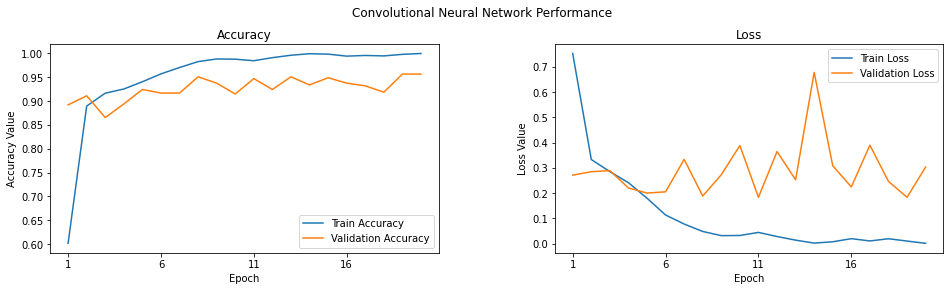

In [22]:
title='Convolutional Neural Network Performance'
plot_history(history, title)

# Results

In [31]:
print("\nK-Nearest Neighbors accuracy: %.2f%%" % (accuracy_knn*100))
print("\nNaive-Bayes accuracy: %.2f%%" % (accuracy_nb*100))
print("\nRandom Forest accuracy: %.2f%%" % (accuracy_rf*100))
print("\nSupport Vector Machine accuracy: %.2f%%" % (accuracy_svm*100))
print("\nLogistic Regression accuracy: %.2f%%" % (accuracy_log*100))
print("\nMulti-layer Perceptron accuracy: %.2f%%" % (accuracy_mlp*100))
print("\nConvolutional Neural Network accuracy: %.2f%%" % accuracy_cnn)


K-Nearest Neighbors accuracy: 76.09%

Naive-Bayes accuracy: 81.97%

Random Forest accuracy: 88.05%

Support Vector Machine accuracy: 83.11%

Logistic Regression accuracy: 84.25%

Multi-layer Perceptron accuracy: 85.39%

Convolutional Neural Network accuracy: 95.64%


# -  Testing Inaspeechsegmenter

*Creating Folders to convert .flac to .mp3 format*

In [32]:
import os

# Directory
directory = "Mp3 Audio Files"

os.mkdir(directory)

mp3_path = "/content/Mp3 Audio Files"

for folder in ('84','1462','1673','1919','1988','2035','2078','2086','2428','2803','2902','3000'):
  path = os.path.join(mp3_path, folder)
  os.mkdir(path)

In [38]:
#Library to Convert .flac files to .mp3
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


*Converting .flac to .mp3 and saving it in respective folders*

In [39]:
from pydub import AudioSegment
import regex as re

root = "LibriSpeech/"
speaker = {}
f = open("LibriSpeech/SPEAKERS.TXT", "r", encoding="UTF8").readlines()
for idx, line in enumerate(f):
    if idx > 11:
        parsed = re.split('\s+',line)
        if parsed[4] == 'dev-clean':
          speaker[parsed[0]] = (parsed[2])

root = "LibriSpeech/dev-clean/"
mp3_path = "/content/Mp3 Audio Files"
for path, subdirs, files in os.walk(root):
    for name in files:
        speaker_id = path.split('/')[2]
        if speaker_id in ('84','1462','1673','1919','1988','2035','2078','2086','2428','2803','2902','3000'):
          if name.endswith(".flac"):
            audio = os.path.join(path, name)
            flac_audio = AudioSegment.from_file(os.path.join(path, name), "flac")
            mp3_name = re.sub(r'\bflac\b','mp3',name)
            folder_path = os.path.join(mp3_path, speaker_id)
            flac_audio.export(os.path.join(folder_path, mp3_name), format="mp3")

*Installing libraries for audio segmentation and Gender Prediction*

In [40]:
!pip install inaSpeechSegmenter
!apt install ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 78 kB 5.0 MB/s 
     |████████████████████████████████| 89 kB 9.8 MB/s 
     |████████████████████████████████| 65 kB 5.2 MB/s 
     |████████████████████████████████| 130 kB 64.1 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=cda45f510f41b0eb1dadc724c12e320f693a8dc189646145da5687b07d57996d
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built docopt
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


*Processing Audio Files and Generating Results*

In [ ]:
from inaSpeechSegmenter import Segmenter
from inaSpeechSegmenter.export_funcs import seg2csv, seg2textgrid
import warnings
warnings.filterwarnings('ignore')
import os
import re
dict_gender = {'84': 'Female','1462': 'Female', '1673': 'Female', '1919': 'Female', '1988': 'Female','2035': 'Female',
               '2078': 'Male', '2086': 'Male','2428': 'Male', '2803': 'Male','2902': 'Male','3000': 'Male',}
result_dict = dict()
folder_list = []
mp3_path = "/content/Mp3 Audio Files"
seg = Segmenter()
tot_accuracy = []
for path, subdirs, files in os.walk(mp3_path):
  speaker_id = path.split('/')
  tot_female = 0
  tot_male = 0
  for name in files:
    x = re.search(r".+?(?=-)",name)
    folderid = x.group()
    if folderid not in folder_list:
      print('**********************************************************************')
      print('Speaker ID :',folderid)
      print('**********************************************************************')
      folder_list.append(folderid)
    segmentation = seg(os.path.join(path, name))
    for voice_type,start_time,end_time in segmentation:
      if voice_type == 'female':
        female_total_time = round(end_time,2) - round(start_time,2)
        tot_female = tot_female + female_total_time
      elif voice_type == 'male':
        male_total_time = round(end_time,2) - round(start_time,2)
        tot_male = tot_male + male_total_time

  tot_time = tot_female + tot_male
  key = dict_gender[folderid]
  if tot_time!=0:
      if key == 'Female':
        Accuracy = (tot_female/tot_time)*100
        print('Voice Type:','Female')
        print("Accuracy: %.2f%%" % (round(Accuracy,2)))
        tot_accuracy.append(Accuracy)
      else:
        Accuracy = (tot_male/tot_time)*100
        print('Voice Type:','Male')
        print("Accuracy: %.2f%%" % (round(Accuracy,2)))
        tot_accuracy.append(Accuracy)
